In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import scipy.sparse as sp_sparse
import scanpy as sc
from math import log
from statistics import median
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras.losses

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Preparation

In [4]:
adata = sc.read_10x_mtx(
    '/home/ahmadazim/data/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata.var_names_make_unique()

In [5]:
data = pd.DataFrame.sparse.from_spmatrix(adata.X)
print('Working on {} cells and {} genes'.format(*data.shape))

Working on 2700 cells and 32738 genes


In [6]:
# Filter out genes that are not expressed in any cells
geneSum = data.sum(axis=0)
x = geneSum.index[geneSum == 0].tolist()
data = data.drop(x, axis = 1)
data.shape


(2700, 16634)

In [7]:
# Normalizing data (using method from Rao, et al.)
cellSum  = data.sum(axis=1)
median_j = median(cellSum)
npData = np.asarray(data)
for j in range(2700):
    cellSum_j = cellSum[j]
    for i in range(16634):
        npData[j,i] = log( ( (npData[j,i])/(cellSum_j) * median_j ) + 1)

In [8]:
dataNorm = pd.DataFrame(npData)
dataNorm

0      1      2      3      4      5      6      7      8      9      \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2695    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2696    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2697    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2698    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2699    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      ...  16624     16625  16626  16627     16628  16629     16630  16631  \
0     ...    0.0  1.532536    0.0    0.0  0.000000    0.0  0.000000    0.0   
1     ...    0.0  1.522734    0.0    0.0  0.370248    0.0  0.000000    0.0   
2     ...    0.0  1.332558    0.0    0.0  0.000000    0.0  0.000000    0.0   
3     ...    0.0  0.980213    0.0    0.0  0.000000    0.0  0.000000    0.0   
4     ...    0.0  1.175435    0.0    0.0  0.000000    0.0  0.000000    0.0   
...   ...    ...       ...    ...    ...       ...    ...       ...    ...   
2695  ...    0.0  0.491513    0.0    0.0  0.000000    0.0  0.000000    0.0   
2696  ...    0.0  1.266796    0.0    0.0  0.000000    0.0  0.000000    0.0   
2697  ...    0.0  1.827533    0.0    0.0  0.000000    0.0  0.000000    0.0   
2698  ...    0.0  1.145975    0.0    0.0  0.000000    0.0  1.145975    0.0   
2699  ...    0.0  1.463349    0.0    0.0  0.000000    0.0  0.000000    0.0   

      16632  16633  
0       0.0    0.0  
1       0.0    0.0  
2       0.0    0.0  
3       0.0    0.0  
4       0.0    0.0  
...     ...    ...  
2695    0.0    0.0  
2696    0.0    0.0  
2697    0.0    0.0  
2698    0.0    0.0  
2699    0.0    0.0  

[2700 rows x 16634 columns]

# Trying Autoencoder with Dense Layers (not Conv.)
Since the conv failed so bad. Want to see if beacause of Conv or not...

In [9]:
model = Sequential()
fullData = np.asarray(dataNorm)
n_genes = fullData.shape[1]

#add model layers
model.add(layers.Input(shape= n_genes))
model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(n_genes, activation='relu'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              136273920 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              5

In [10]:
# Train test split (random train = 90%)
# trainProp = 0.9
# n_cells = fullData.shape[0]

# train_idx = np.random.choice(n_cells, int(n_cells * trainProp), replace= False)
# test_idx = np.array(list(set(range(n_cells)) - set(train_idx)))
# trainAE = fullData[train_idx, :]
# testAE = fullData[test_idx, :]

In [11]:
def nzMSE(y_true, y_pred): 
    omega = tf.sign(y_true)  # 0 if 0, 1 if > 0
    mse_nz = tf.reduce_mean(tf.multiply(tf.pow( (y_pred - y_true), 2), omega))
    return mse_nz

model.compile(optimizer='adam', 
              loss= nzMSE)

In [12]:
# Train model
AEresults = model.fit(x= fullData, 
                      y= fullData, 
                      epochs= 50, 
                      batch_size= 128)

Epoch 1/50
22/22 [==============================] - 33s 2s/step - loss: 0.0542
Epoch 2/50
22/22 [==============================] - 33s 2s/step - loss: 0.0142
Epoch 3/50
22/22 [==============================] - 33s 2s/step - loss: 0.0118
Epoch 4/50
22/22 [==============================] - 33s 2s/step - loss: 0.0114
Epoch 5/50
22/22 [==============================] - 33s 2s/step - loss: 0.0112
Epoch 6/50
22/22 [==============================] - 33s 2s/step - loss: 0.0111
Epoch 7/50
22/22 [==============================] - 33s 2s/step - loss: 0.0111
Epoch 8/50
22/22 [==============================] - 33s 2s/step - loss: 0.0111
Epoch 9/50
22/22 [==============================] - 33s 2s/step - loss: 0.0111
Epoch 10/50
22/22 [==============================] - 33s 2s/step - loss: 0.0110
Epoch 11/50
22/22 [==============================] - 33s 2s/step - loss: 0.0110
Epoch 12/50
22/22 [==============================] - 33s 2s/step - loss: 0.0110
Epoch 13/50
22/22 [==============================

In [13]:
predicted = pd.DataFrame(model.predict(fullData))
predicted
# Notes on using MSE...
    # At least it's not all zeros this time, but still needs some work
    # Need to build a loss function to penalize for zeros 

# Now added loss function described in paper (nonzero MSE)...
    # Did pretty well!!
    # 95% zeros --> 28% zeros

0         1         2      3         4         5         6      \
0     0.644699  0.615847  0.625472    0.0  0.501049  0.648746  0.560258   
1     0.453491  0.525993  0.426900    0.0  0.423877  0.457602  0.462991   
2     0.578615  0.565829  0.550378    0.0  0.457496  0.578940  0.519257   
3     0.615820  0.609194  0.474617    0.0  0.486748  0.573460  0.491143   
4     1.040997  0.928484  0.966896    0.0  0.674870  1.060831  0.724803   
...        ...       ...       ...    ...       ...       ...       ...   
2695  0.528582  0.612031  0.382094    0.0  0.467101  0.529732  0.468855   
2696  0.513520  0.519115  0.484026    0.0  0.415652  0.517431  0.479249   
2697  0.787563  0.727320  0.763782    0.0  0.566927  0.805800  0.667663   
2698  1.019015  0.889184  0.972842    0.0  0.666956  1.036566  0.786064   
2699  0.694864  0.653735  0.689772    0.0  0.526323  0.707341  0.579988   

         7         8         9      ...     16624     16625     16626  \
0     0.674658  0.624430  0.631120  ...  0.694422  1.584206  0.616692   
1     0.506794  0.399396  0.419854  ...  0.503976  1.378485  0.417132   
2     0.614749  0.532391  0.550627  ...  0.627102  1.477685  0.539611   
3     0.583930  0.605253  0.540065  ...  0.645224  1.496281  0.732129   
4     1.000385  1.143123  1.100655  ...  1.175382  1.685538  1.113950   
...        ...       ...       ...  ...       ...       ...       ...   
2695  0.525147  0.513112  0.481153  ...  0.606521  1.398259  0.553993   
2696  0.564715  0.450048  0.469374  ...  0.594361  1.438606  0.454190   
2697  0.784525  0.800498  0.833474  ...  0.871069  1.502598  0.838944   
2698  0.981142  1.052965  1.090339  ...  1.148495  1.680532  1.110297   
2699  0.699385  0.721004  0.716177  ...  0.762457  1.555358  0.705831   

         16627     16628     16629     16630     16631     16632     16633  
0     0.692175  0.689334  0.699753  0.620800  0.674112  0.662895  0.651730  
1     0.563279  0.433897  0.556454  0.414860  0.566927  0.408417  0.397848  
2     0.622228  0.596680  0.625513  0.540102  0.615264  0.585039  0.567807  
3     0.613873  0.678701  0.628183  0.529978  0.598969  0.624350  0.612514  
4     0.927934  1.298193  0.957127  1.123086  0.956523  1.371625  1.189652  
...        ...       ...       ...       ...       ...       ...       ...  
2695  0.574563  0.599204  0.579873  0.432415  0.582001  0.502517  0.503926  
2696  0.559157  0.509775  0.572554  0.458896  0.565418  0.540253  0.479777  
2697  0.808201  0.880864  0.812042  0.847206  0.791945  0.823470  0.845636  
2698  0.956226  1.220541  0.984123  1.110592  0.966298  1.192011  1.135028  
2699  0.745921  0.757040  0.750783  0.711621  0.712168  0.725040  0.737784  

[2700 rows x 16634 columns]

In [14]:
data.eq(0).values.sum()/(2700*16634)
predicted.eq(0).values.sum()/(2700*16634)

0.9490805534402985

0.13792036836644267

Working on 2700 cells and 16634 genes
Data imported.


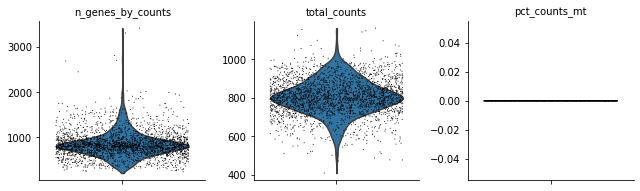

Trying to set attribute `.var` of view, copying.
QC steps done.
Plotting PCA and UMAP...


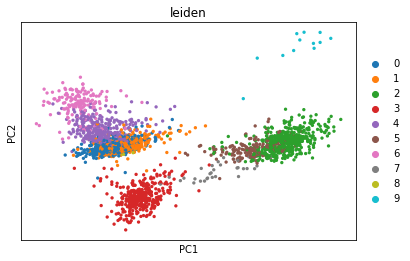

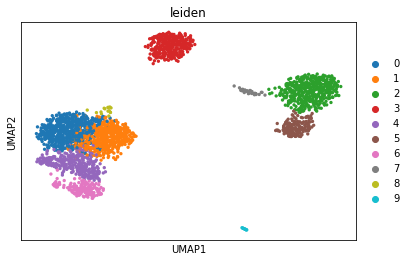

In [15]:
# run autoClust module/function on unImputed data
import autoCluster as ac
ac.cluster(inputMat= fullData, modelName= 'unImputed')

Working on 2700 cells and 16634 genes
Data imported.


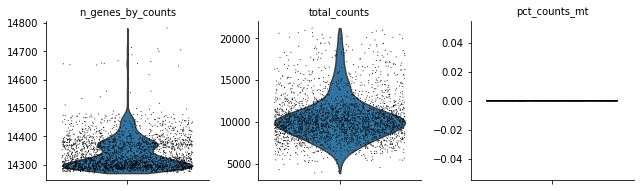

Trying to set attribute `.var` of view, copying.
QC steps done.
Plotting PCA and UMAP...


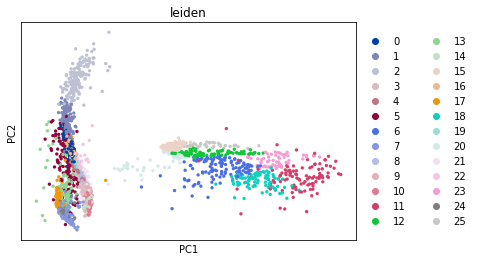

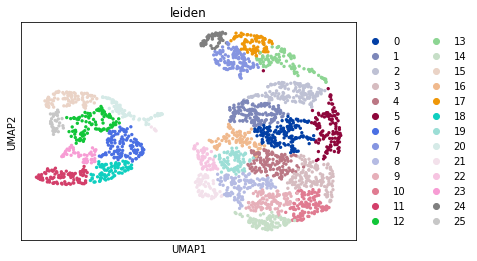

In [16]:
# run autoClust module/function on imputed data (AEnn)
predictedNP = np.asarray(predicted)
import autoCluster as ac
ac.cluster(inputMat= predictedNP, modelName= 'AEnn')

# Testing dropout layers

In [37]:
modelD = Sequential()
fullData = np.asarray(dataNorm)
n_genes = fullData.shape[1]

#add model layers
modelD.add(layers.Input(shape= n_genes))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(8192, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(4096, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(1024, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(256, activation='relu'))

modelD.add(layers.Dense(32, activation='relu'))

modelD.add(layers.Dense(256, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(1024, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(4096, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(8192, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(n_genes, activation='relu'))

modelD.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_34 (Dropout)         (None, 16634)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 8192)              136273920 
_________________________________________________________________
dropout_35 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 4096)              33558528  
_________________________________________________________________
dropout_36 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dropout_37 (Dropout)         (None, 1024)             

In [38]:
modelD.compile(optimizer='adam', 
               loss=nzMSE)

In [39]:
# Train model
dropoutAdded = modelD.fit(x= fullData, 
                          y= fullData, 
                          epochs= 30,
                          batch_size= 64)

Epoch 1/30
43/43 [==============================] - 49s 1s/step - loss: 0.4926
Epoch 2/30
43/43 [==============================] - 49s 1s/step - loss: 0.0089
Epoch 3/30
43/43 [==============================] - 49s 1s/step - loss: 0.0076
Epoch 4/30
43/43 [==============================] - 49s 1s/step - loss: 0.0069
Epoch 5/30
43/43 [==============================] - 49s 1s/step - loss: 0.0063
Epoch 6/30
43/43 [==============================] - 49s 1s/step - loss: 0.0061
Epoch 7/30
43/43 [==============================] - 49s 1s/step - loss: 0.0060
Epoch 8/30
43/43 [==============================] - 49s 1s/step - loss: 0.0058
Epoch 9/30
43/43 [==============================] - 49s 1s/step - loss: 0.0055
Epoch 10/30
43/43 [==============================] - 49s 1s/step - loss: 0.0053
Epoch 11/30
43/43 [==============================] - 49s 1s/step - loss: 0.0052
Epoch 12/30
43/43 [==============================] - 49s 1s/step - loss: 0.0051
Epoch 13/30
43/43 [==============================

In [40]:
predDropout = pd.DataFrame(modelD.predict(fullData))
predDropout

0         1         2         3         4         5         6      \
0     0.594399  0.554800  0.580776  0.451296  0.490756  0.635211  0.557491   
1     0.410409  0.425685  0.357115  0.339091  0.393534  0.455529  0.444751   
2     0.550811  0.532833  0.512268  0.432008  0.464983  0.587332  0.530373   
3     0.569740  0.612328  0.393066  0.461945  0.479149  0.591674  0.514124   
4     0.770214  0.719095  0.657923  0.535593  0.542554  0.807079  0.586316   
...        ...       ...       ...       ...       ...       ...       ...   
2695  0.508021  0.555548  0.329847  0.414746  0.446111  0.517964  0.480718   
2696  0.501696  0.499953  0.444810  0.401741  0.440020  0.535399  0.499547   
2697  0.719945  0.657785  0.713573  0.534654  0.561873  0.787140  0.621790   
2698  0.843009  0.765544  0.817910  0.616142  0.626211  0.926085  0.685934   
2699  0.629987  0.579540  0.624725  0.471940  0.512044  0.677119  0.576124   

         7         8         9      ...     16624     16625     16626  \
0     0.694422  0.666151  0.628114  ...  0.657234  1.559663  0.599576   
1     0.534091  0.395706  0.367614  ...  0.449625  1.436206  0.346224   
2     0.653680  0.602529  0.581433  ...  0.604540  1.496657  0.552394   
3     0.648656  0.603561  0.517896  ...  0.619657  1.469712  0.621941   
4     0.797507  0.962051  0.897599  ...  0.891657  1.508208  0.851860   
...        ...       ...       ...  ...       ...       ...       ...   
2695  0.595261  0.497098  0.428290  ...  0.545034  1.431057  0.527772   
2696  0.609686  0.523026  0.503283  ...  0.548784  1.464805  0.484608   
2697  0.803053  0.858810  0.782851  ...  0.836545  1.643787  0.795495   
2698  0.898945  1.034080  0.941604  ...  1.014370  1.734367  0.975870   
2699  0.727070  0.720626  0.667254  ...  0.705168  1.593037  0.648465   

         16627     16628  16629     16630     16631     16632     16633  
0     0.669026  0.641672    0.0  0.608259  0.626552  0.590174  0.572003  
1     0.502974  0.383717    0.0  0.353268  0.478344  0.365217  0.323641  
2     0.608857  0.586537    0.0  0.559267  0.607947  0.544859  0.537673  
3     0.556505  0.577999    0.0  0.552388  0.655734  0.527641  0.543221  
4     0.716142  0.964947    0.0  0.832836  0.731233  0.938852  0.842828  
...        ...       ...    ...       ...       ...       ...       ...  
2695  0.502397  0.485652    0.0  0.464395  0.596115  0.437848  0.454123  
2696  0.560575  0.513919    0.0  0.487026  0.567316  0.479032  0.465597  
2697  0.777826  0.852129    0.0  0.788372  0.720769  0.757665  0.741964  
2698  0.868554  1.069101    0.0  0.953388  0.811372  0.928830  0.909857  
2699  0.709077  0.696222    0.0  0.655495  0.648595  0.634518  0.611994  

[2700 rows x 16634 columns]

In [41]:
data.eq(0).values.sum()/(2700*16634)
predDropout.eq(0).values.sum()/(2700*16634)

0.9490805534402985

0.01599049692953745

Working on 2700 cells and 16634 genes
Data imported.


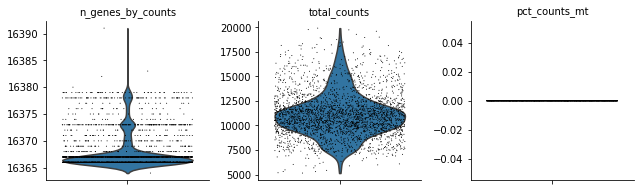

Trying to set attribute `.var` of view, copying.
QC steps done.
Plotting PCA and UMAP...


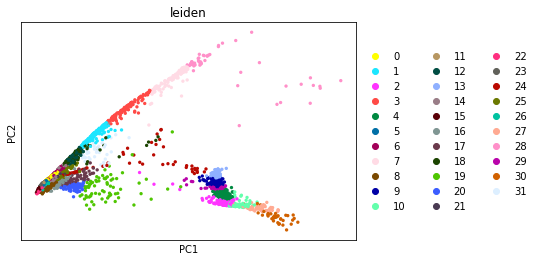

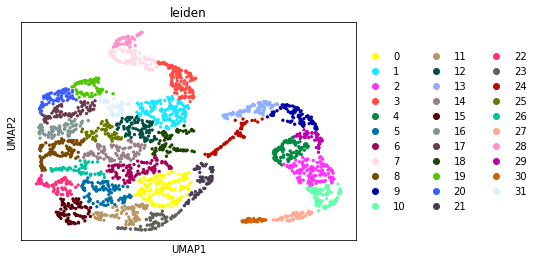

In [42]:
# run autoClust module/function on imputed data (AEnn)
predDropout_np = np.asarray(predDropout)
import autoCluster as ac
ac.cluster(inputMat= predDropout_np, modelName= 'AEnn_moreDropout')

Try with regular MSE??

In [43]:
modelD = Sequential()
fullData = np.asarray(dataNorm)
n_genes = fullData.shape[1]

#add model layers
modelD.add(layers.Input(shape= n_genes))
modelD.add(layers.Dense(8192, activation='relu'))
modelD.add(layers.Dense(4096, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(1024, activation='relu'))
modelD.add(layers.Dense(256, activation='relu'))

modelD.add(layers.Dense(32, activation='relu'))

modelD.add(layers.Dense(256, activation='relu'))
modelD.add(layers.Dense(1024, activation='relu'))
modelD.add(layers.Dropout(0.3))
modelD.add(layers.Dense(4096, activation='relu'))
modelD.add(layers.Dense(8192, activation='relu'))
modelD.add(layers.Dense(n_genes, activation='relu'))

modelD.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 8192)              136273920 
_________________________________________________________________
dense_61 (Dense)             (None, 4096)              33558528  
_________________________________________________________________
dropout_42 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_63 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_64 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_65 (Dense)             (None, 256)              

In [48]:
modelD.compile(optimizer='adam', 
               loss="mean_squared_error")

In [49]:
# Train model
dropoutAdded = modelD.fit(x= fullData, 
                          y= fullData, 
                          epochs= 30,
                          batch_size= 64)

Epoch 1/30
43/43 [==============================] - 49s 1s/step - loss: 0.0455
Epoch 2/30
43/43 [==============================] - 49s 1s/step - loss: 0.0355
Epoch 3/30
43/43 [==============================] - 48s 1s/step - loss: 0.0354
Epoch 4/30
43/43 [==============================] - 48s 1s/step - loss: 0.0354
Epoch 5/30
43/43 [==============================] - 48s 1s/step - loss: 0.0352
Epoch 6/30
43/43 [==============================] - 48s 1s/step - loss: 0.0351
Epoch 7/30
43/43 [==============================] - 49s 1s/step - loss: 0.0351
Epoch 8/30
43/43 [==============================] - 49s 1s/step - loss: 0.0348
Epoch 9/30
43/43 [==============================] - 48s 1s/step - loss: 0.0343
Epoch 10/30
43/43 [==============================] - 49s 1s/step - loss: 0.0343
Epoch 11/30
43/43 [==============================] - 49s 1s/step - loss: 0.0342
Epoch 12/30
43/43 [==============================] - 49s 1s/step - loss: 0.0341
Epoch 13/30
43/43 [==============================

In [50]:
predDropout_MSE = pd.DataFrame(modelD.predict(fullData))
predDropout_MSE

0      1      2      3      4      5      6      7      8      9      \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2695    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2696    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2697    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2698    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2699    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      ...  16624     16625  16626  16627  16628  16629  16630  16631  16632  \
0     ...    0.0  1.620880    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     ...    0.0  1.551050    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     ...    0.0  1.257882    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     ...    0.0  1.332100    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     ...    0.0  0.944755    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...   ...    ...       ...    ...    ...    ...    ...    ...    ...    ...   
2695  ...    0.0  1.202746    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2696  ...    0.0  1.041271    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2697  ...    0.0  1.138228    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2698  ...    0.0  1.364542    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2699  ...    0.0  1.040722    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      16633  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
2695    0.0  
2696    0.0  
2697    0.0  
2698    0.0  
2699    0.0  

[2700 rows x 16634 columns]

In [51]:
data.eq(0).values.sum()/(2700*16634)
predDropout_MSE.eq(0).values.sum()/(2700*16634)

0.9490805534402985

0.9873935135086993

Working on 2700 cells and 16634 genes
Data imported.


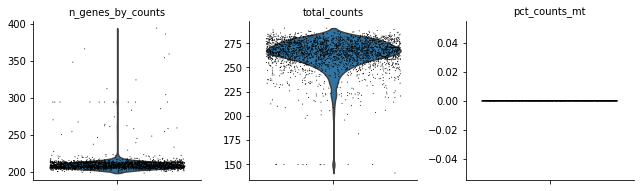

Trying to set attribute `.var` of view, copying.
QC steps done.
Plotting PCA and UMAP...


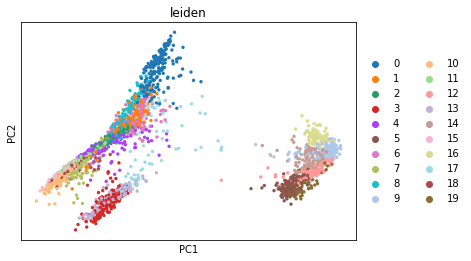

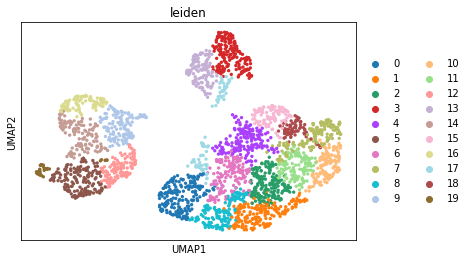

In [52]:
# run autoClust module/function on imputed data (AEnn)
predDropoutMSE_np = np.asarray(predDropout_MSE)
import autoCluster as ac
ac.cluster(inputMat= predDropoutMSE_np, modelName= 'AEnn_MSE')